In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from construct import *
import scipy.signal

import struct
import collections
import pathlib
import string

plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
TMPrimaryHeader = BitStruct(
    'transfer_frame_version_number' / BitsInteger(2),
    'spacecraft_id' / BitsInteger(10),
    'virtual_channel_id' / BitsInteger(3),
    'ocf_flag' / Flag,
    'master_channel_frame_count' / BitsInteger(8),
    'virtual_channel_frame_count' / BitsInteger(8),
    'secondary_header_flag' / Flag,
    'synch_flag' / Flag,
    'packet_order_flag' / Flag,
    'segment_length_id' / BitsInteger(2),
    'first_header_pointer' / BitsInteger(11)
)

TransferFrameSecondaryHeaderId = BitStruct(
    'version_number' / BitsInteger(2),
    'header_length' / BitsInteger(6)
)

CLCW = BitStruct(
    'control_word_type' / Flag,
    'clcw_version_number' / BitsInteger(2),
    'status_field' / BitsInteger(3),
    'cop_in_effect' / BitsInteger(2),
    'virtual_channel_identification' / BitsInteger(6),
    'rsvd_spare' / BitsInteger(2),
    'no_rf_avail' / Flag,
    'no_bit_lock' / Flag,
    'lock_out' / Flag,
    'wait' / Flag,
    'retransmit' / Flag,
    'farm_b_counter' / BitsInteger(2),
    'rsvd_spare2' / BitsInteger(1),
    'report_value' / BitsInteger(8)
)

SpacePacketPrimaryHeader = BitStruct(
    'ccsds_version' / BitsInteger(3),
    'packet_type' / BitsInteger(1),
    'secondary_header_flag' / Flag,
    'APID' / BitsInteger(11),
    'sequence_flags' / BitsInteger(2),
    'packet_sequence_count_or_name' / BitsInteger(14),
    'data_length' / BitsInteger(16)
)

In [3]:
def load_frames(path):
    frame_size = 223 * 5 - 2
    frames = np.fromfile(path, dtype = 'uint8')
    frames = frames[:frames.size//frame_size*frame_size].reshape((-1, frame_size))
    return frames

In [4]:
frames0 = load_frames('dart_8421657814Hz_09-24-50_24-11-2021.u8')
frames = np.concatenate((
    frames0,
    load_frames('dart_8421657814Hz_09-34-42_24-11-2021.u8'),
))
frames.shape[0]

438

## TM Primary Headers

DART frames use the [TM Space Data Link](https://public.ccsds.org/Pubs/132x0b3.pdf) protocol. The spacecraft ID is `0x13E` (318). There are two virtual channels in use: 0 and 7. The Operational Control Field and Secondary Header are used.

In [5]:
tm_headers = [TMPrimaryHeader.parse(f) for f in frames]

In [6]:
collections.Counter([h.transfer_frame_version_number for h in tm_headers])

Counter({0: 438})

In [7]:
collections.Counter([h.spacecraft_id for h in tm_headers])

Counter({318: 438})

In [8]:
collections.Counter([h.virtual_channel_id for h in tm_headers])

Counter({0: 228, 7: 210})

In [9]:
tm_headers[:5]

[Container(transfer_frame_version_number=0, spacecraft_id=318, virtual_channel_id=0, ocf_flag=True, master_channel_frame_count=102, virtual_channel_frame_count=237, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=2046),
 Container(transfer_frame_version_number=0, spacecraft_id=318, virtual_channel_id=0, ocf_flag=True, master_channel_frame_count=104, virtual_channel_frame_count=239, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=2046),
 Container(transfer_frame_version_number=0, spacecraft_id=318, virtual_channel_id=0, ocf_flag=True, master_channel_frame_count=106, virtual_channel_frame_count=240, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=2046),
 Container(transfer_frame_version_number=0, spacecraft_id=318, virtual_channel_id=0, ocf_flag=True, master_channel_frame_count=107, virtual_chann

In [10]:
mcfc = np.array([h.master_channel_frame_count for h in tm_headers])
mcfc_unwrap = np.uint32(np.round(np.unwrap(2*np.pi*mcfc.astype('float')/256)/(2*np.pi)*256))
# Some manual corrections for glitches
# These have been determined by looking at the timestamps below
mcfc_unwrap[mcfc_unwrap > 1500] += 256
mcfc_unwrap[frames0.shape[0]:] += 256*15
mcfc_unwrap[1:][mcfc_unwrap[1:] < mcfc_unwrap[:-1]] += 256

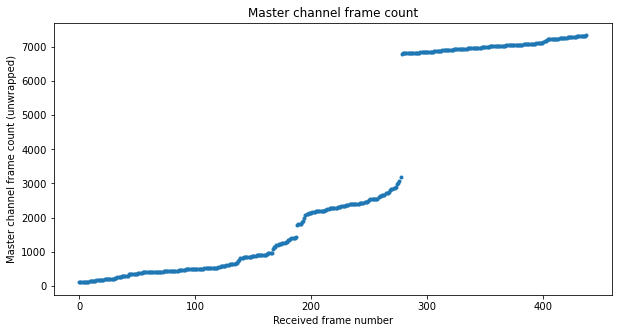

In [11]:
plt.plot(mcfc_unwrap, '.')
plt.title('Master channel frame count')
plt.ylabel('Master channel frame count (unwrapped)')
plt.xlabel('Received frame number');

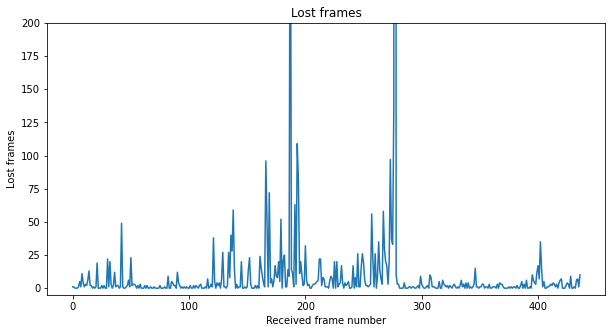

In [12]:
plt.plot(np.diff(mcfc_unwrap)-1)
plt.title('Lost frames')
plt.ylabel('Lost frames')
plt.xlabel('Received frame number')
plt.ylim((-5, 200));

## TM Secondary Header: timestamps

Secondary headers are 8 bytes long. The first byte is the transfer frame secondary header ID field. The second byte is always `0x34`. Its purpose is unknown. The last 6 bytes contain a 48-bit timestamp as the number of units of $2^{-16}$ seconds elapsed since 2010-01-01T00:00:00Z.

In [13]:
secondary_header = frames[:, TMPrimaryHeader.sizeof():14]
np.all(secondary_header[:, :2] == secondary_header[0, :2])

True

In [14]:
print(TransferFrameSecondaryHeaderId.parse(secondary_header[0]))

Container: 
    version_number = 0
    header_length = 7


In [15]:
hex(secondary_header[0, 1])

'0x34'

In [16]:
timestamp_bytes = 6
timestamp = np.sum(secondary_header[:, -timestamp_bytes:].astype('uint64') 
                   * 2**np.arange((timestamp_bytes-1)*8, -1, -8), axis=1) / 2**16

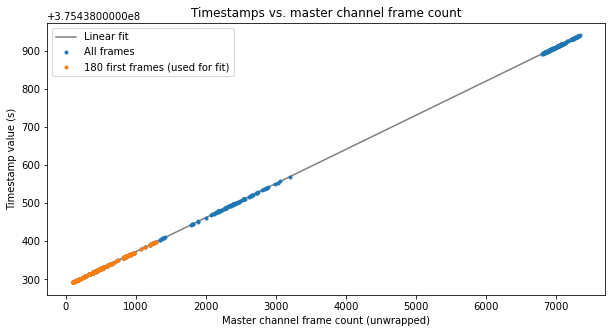

In [17]:
poly = np.polyfit(mcfc_unwrap[:180], timestamp[:180], 1)
plt.plot(mcfc_unwrap, np.polyval(poly, mcfc_unwrap), color='grey', label='Linear fit')
plt.plot(mcfc_unwrap, timestamp, '.', label='All frames')
plt.plot(mcfc_unwrap[:180], timestamp[:180], '.', label='180 first frames (used for fit)')
plt.title('Timestamps vs. master channel frame count')
plt.xlabel('Master channel frame count (unwrapped)')
plt.ylabel('Timestamp value (s)')
plt.legend();

In [18]:
poly

array([8.95655571e-02, 3.75438283e+08])

In [19]:
t_frame = (223*8*5 + 4 + 32)*6/600e3
poly[0] / t_frame

1.000062049311266

In [20]:
epoch = np.datetime64('2010-01-01')
timestamp_datetime = epoch + (1e9*timestamp)*np.timedelta64(1, 'ns')
timestamp_datetime[0], timestamp_datetime[-1]

(numpy.datetime64('2021-11-24T08:24:52.047103872'),
 numpy.datetime64('2021-11-24T08:35:40.158279424'))

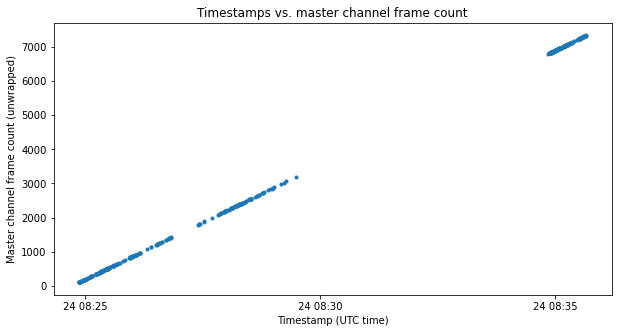

In [21]:
plt.plot(timestamp_datetime, mcfc_unwrap, '.')
plt.title('Timestamps vs. master channel frame count')
plt.xlabel('Timestamp (UTC time)')
plt.ylabel('Master channel frame count (unwrapped)');

## Operational Control Field

In these recordings the Operation Control Field always contains the same values. It contains a communications link control word showing uplink lock.

In [22]:
ocf = frames[:, -4:]
np.all(ocf == ocf[0])

True

In [23]:
ocf[0]

array([ 1, 20,  4,  0], dtype=uint8)

In [24]:
print(CLCW.parse(ocf[0]))

Container: 
    control_word_type = False
    clcw_version_number = 0
    status_field = 0
    cop_in_effect = 1
    virtual_channel_identification = 5
    rsvd_spare = 0
    no_rf_avail = False
    no_bit_lock = False
    lock_out = False
    wait = False
    retransmit = False
    farm_b_counter = 2
    rsvd_spare2 = 0
    report_value = 0


## Virtual channel 0

Virtual channel 0 corresponds to only idle data frames. The transfer frame data field is filled with an 8-bit counter, which wraps around 4 times throughout each frame.

In [25]:
vc0_frames = np.array([f for f in frames if TMPrimaryHeader.parse(f).virtual_channel_id == 0])

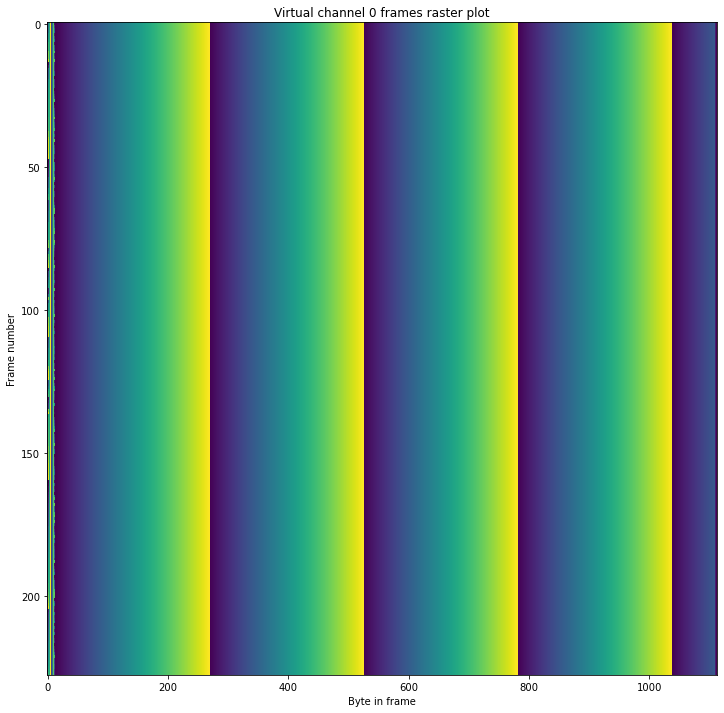

In [26]:
plt.figure(figsize=(12, 12), facecolor='w')
plt.imshow(vc0_frames, aspect='auto', interpolation='None')
plt.title('Virtual channel 0 frames raster plot')
plt.ylabel('Frame number')
plt.xlabel('Byte in frame');

In [27]:
idle = vc0_frames[:, 14:-4]
np.all(idle == np.arange(idle.shape[1], dtype='uint8'))

True

## Virtual channel 7

Virtual channel 7 contains the useful data. The first header pointer of the TM Primary Header is used to point to the beginning of the packets. However, these are not CCSDS Space Packets. At the location indicated by the first header pointer we find some header that seems to contain a counter or timestamp. In the first packets this starts by by `0x1660bbd3`, but this value keeps increasing in later packets.

It is not know how the length of each packet is indicated. A heuristic approach can be used to extract the packets by searching for the value of the counter or an increased version of it. We see that there are packets of several different sizes.

In [28]:
vc7_frames = np.array([f for f in frames if TMPrimaryHeader.parse(f).virtual_channel_id == 7])

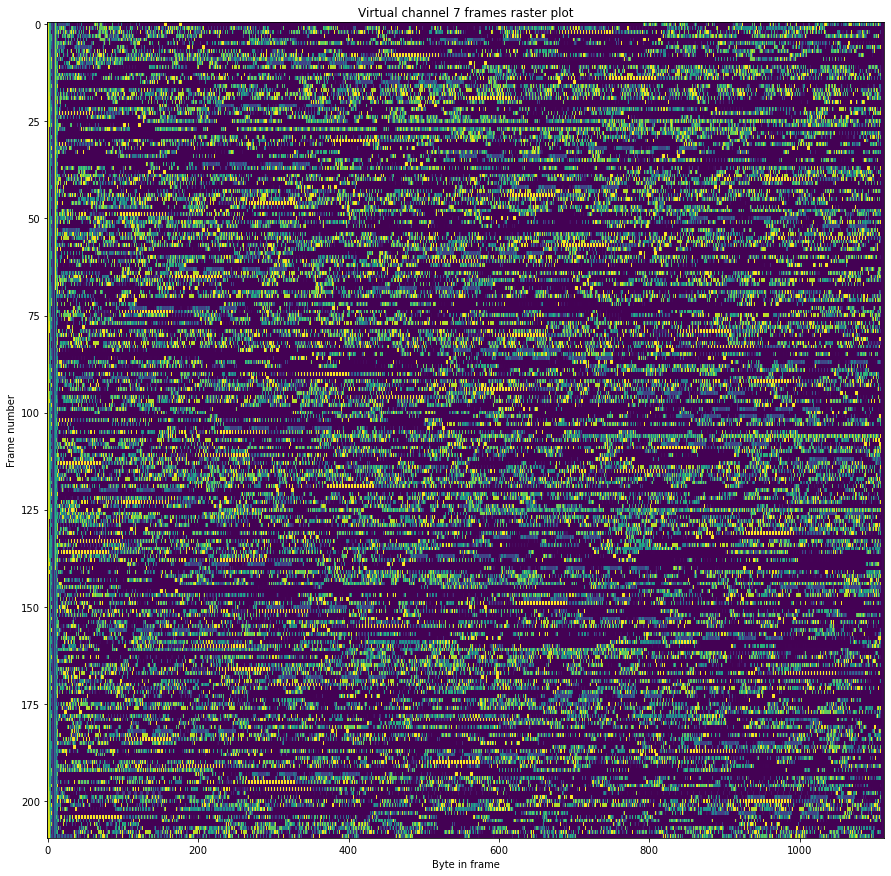

In [29]:
plt.figure(figsize=(15, 15), facecolor='w')
plt.imshow(vc7_frames, aspect='auto', interpolation='None')
plt.title('Virtual channel 7 frames raster plot')
plt.ylabel('Frame number')
plt.xlabel('Byte in frame');

In [30]:
TMPrimaryHeader.parse(vc7_frames[0])

Container(transfer_frame_version_number=0, spacecraft_id=318, virtual_channel_id=7, ocf_flag=True, master_channel_frame_count=108, virtual_channel_frame_count=164, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=48)

In [31]:
SpacePacketPrimaryHeader.parse(vc7_frames[0, 20:][48:])

Container(ccsds_version=0, packet_type=1, secondary_header_flag=False, APID=1632, sequence_flags=2, packet_sequence_count_or_name=15315, data_length=51776)

In [32]:
vc7_frames[0, 20:][48:][:20]

array([ 22,  96, 187, 211, 202,  64,   0,  16,   0,  16,   0,   0,   0,
         0,   0,   0,   0,   0, 178, 174], dtype=uint8)

In [33]:
TMPrimaryHeader.parse(vc7_frames[1])

Container(transfer_frame_version_number=0, spacecraft_id=318, virtual_channel_id=7, ocf_flag=True, master_channel_frame_count=109, virtual_channel_frame_count=165, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=325)

In [34]:
SpacePacketPrimaryHeader.parse(vc7_frames[1, 20:][325:])

Container(ccsds_version=0, packet_type=1, secondary_header_flag=False, APID=1632, sequence_flags=2, packet_sequence_count_or_name=15315, data_length=58176)

In [35]:
vc7_frames[1, 20:][325:][:20]

array([ 22,  96, 187, 211, 227,  64,  65, 182,  96, 187, 210, 231, 174,
        20,   0,   0,   0,   2,   0,   0], dtype=uint8)

In [36]:
TMPrimaryHeader.parse(vc7_frames[2])

Container(transfer_frame_version_number=0, spacecraft_id=318, virtual_channel_id=7, ocf_flag=True, master_channel_frame_count=111, virtual_channel_frame_count=167, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=8)

In [37]:
vc7_frames[2, 20:][8:][:20]

array([ 22,  96, 187, 211, 251, 125, 254, 250,  48, 200, 249,  51,   0,
        44,   2, 140,   0, 173,   0,   0], dtype=uint8)

In [38]:
TMPrimaryHeader.parse(vc7_frames[3])

Container(transfer_frame_version_number=0, spacecraft_id=318, virtual_channel_id=7, ocf_flag=True, master_channel_frame_count=117, virtual_channel_frame_count=169, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=424)

In [39]:
vc7_frames[3, 20:][424:][:20]

array([ 22,  96, 187, 212, 185,  64,   0, 181,   0, 181,   0,   0,   0,
         0,   0,   0,   0,   0, 115,  20], dtype=uint8)

In [40]:
TMPrimaryHeader.parse(vc7_frames[71])

Container(transfer_frame_version_number=0, spacecraft_id=318, virtual_channel_id=7, ocf_flag=True, master_channel_frame_count=98, virtual_channel_frame_count=146, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=718)

In [41]:
vc7_frames[71, 20:][718:][:20]

array([ 22,  96, 188,   0, 226,  64,  65, 182,  96, 187, 255, 231, 174,
        20,   0,   0,   0,   0,  59, 149], dtype=uint8)

In [42]:
class Defrag:
    def __init__(self):
        self.header = 0x1660bbd3
    
    def defrag(self, data):
        data = bytes(data)
        while True:
            header = self.header_bytes(self.header)
            find = data[len(header):].find(header)
            if find == -1:
                # try increasing the header
                found_header = False
                for offset in range(1, 1024):
                    next_header = self.header_bytes(self.header+offset)
                    if data[len(header):].find(next_header) != -1:
                        self.header += offset
                        found_header = True
                        break
                if found_header:
                    continue
                return
            next_start = find + len(header)
            yield data[:next_start]
            data = data[next_start:]
        
    def header_bytes(self, header):
        return bytes(np.array([header], 'uint32').byteswap().view('uint8'))

In [43]:
defrag = Defrag()
defrags = [list(defrag.defrag(frame[20:][TMPrimaryHeader.parse(frame).first_header_pointer:-4]))
           for frame in vc7_frames]

In [44]:
[(j, len(a)) for j, a in enumerate(defrags)]

[(0, 1),
 (1, 1),
 (2, 14),
 (3, 2),
 (4, 1),
 (5, 0),
 (6, 1),
 (7, 6),
 (8, 11),
 (9, 0),
 (10, 1),
 (11, 13),
 (12, 0),
 (13, 7),
 (14, 14),
 (15, 1),
 (16, 1),
 (17, 11),
 (18, 15),
 (19, 13),
 (20, 1),
 (21, 1),
 (22, 2),
 (23, 6),
 (24, 1),
 (25, 2),
 (26, 0),
 (27, 1),
 (28, 0),
 (29, 1),
 (30, 10),
 (31, 6),
 (32, 2),
 (33, 2),
 (34, 1),
 (35, 1),
 (36, 1),
 (37, 1),
 (38, 1),
 (39, 4),
 (40, 14),
 (41, 5),
 (42, 2),
 (43, 8),
 (44, 14),
 (45, 15),
 (46, 8),
 (47, 1),
 (48, 3),
 (49, 7),
 (50, 2),
 (51, 2),
 (52, 2),
 (53, 1),
 (54, 3),
 (55, 14),
 (56, 8),
 (57, 14),
 (58, 2),
 (59, 1),
 (60, 10),
 (61, 12),
 (62, 1),
 (63, 2),
 (64, 15),
 (65, 8),
 (66, 4),
 (67, 4),
 (68, 1),
 (69, 0),
 (70, 15),
 (71, 0),
 (72, 1),
 (73, 2),
 (74, 7),
 (75, 4),
 (76, 2),
 (77, 11),
 (78, 0),
 (79, 14),
 (80, 13),
 (81, 1),
 (82, 16),
 (83, 14),
 (84, 2),
 (85, 1),
 (86, 2),
 (87, 2),
 (88, 4),
 (89, 0),
 (90, 9),
 (91, 1),
 (92, 14),
 (93, 9),
 (94, 13),
 (95, 2),
 (96, 11),
 (97, 15),
 (98

In [45]:
[[len(b) for b in a] for a in defrags]

[[730],
 [565],
 [64, 64, 64, 64, 64, 64, 64, 64, 76, 208, 48, 66, 52, 98],
 [379, 118],
 [252],
 [],
 [730],
 [48, 66, 52, 98, 76, 414],
 [64, 64, 64, 64, 64, 208, 48, 66, 52, 98, 76],
 [],
 [252],
 [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64],
 [],
 [565, 64, 64, 64, 64, 64, 64],
 [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 208, 48, 66, 52],
 [252],
 [642],
 [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64],
 [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64],
 [64, 64, 64, 64, 64, 64, 64, 208, 48, 66, 52, 98, 76],
 [515],
 [252],
 [565, 64],
 [48, 66, 52, 98, 76, 414],
 [515],
 [118, 208],
 [],
 [208],
 [],
 [642],
 [64, 64, 64, 64, 208, 48, 66, 52, 98, 76],
 [48, 66, 52, 98, 76, 414],
 [379, 252],
 [414, 541],
 [252],
 [642],
 [252],
 [642],
 [730],
 [565, 64, 64, 64],
 [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 208],
 [66, 52, 98, 76, 414],
 [379, 252],
 [64, 64, 64, 64, 64, 64, 64, 64],
 [64, 64, 64, 64, 64, 64, 64, 64, 208, 48, 66, 52, 98, 76],
 [64, 64, 64, 

In [46]:
heads = np.array([np.frombuffer(b[:16], 'uint8') for a in defrags for b in a])

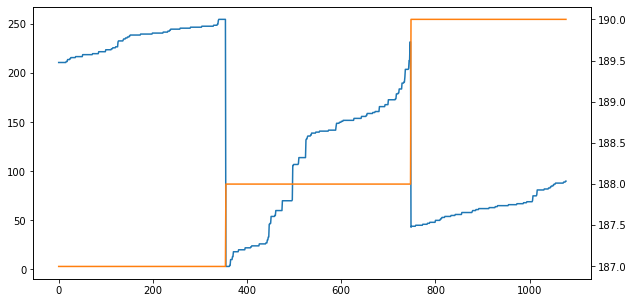

In [47]:
plt.plot(heads[:, 3])
plt.gca().twinx()
plt.plot(heads[:, 2], color='C1')

In [48]:
lengths = collections.Counter([len(b) for a in defrags for b in a])
by_length = {length: np.array([np.frombuffer(b, 'uint8')
                       for a in defrags for b in a if len(b) == length])
             for length in lengths}
lengths

Counter({730: 13,
         565: 18,
         64: 621,
         76: 49,
         208: 48,
         48: 48,
         66: 48,
         52: 48,
         98: 46,
         379: 22,
         118: 6,
         252: 35,
         414: 27,
         642: 13,
         515: 16,
         541: 4,
         545: 6,
         50: 2,
         948: 1,
         78: 5,
         100: 1,
         732: 1})

<ipython-input-49-4b664190d41a>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15, 15), facecolor='w')


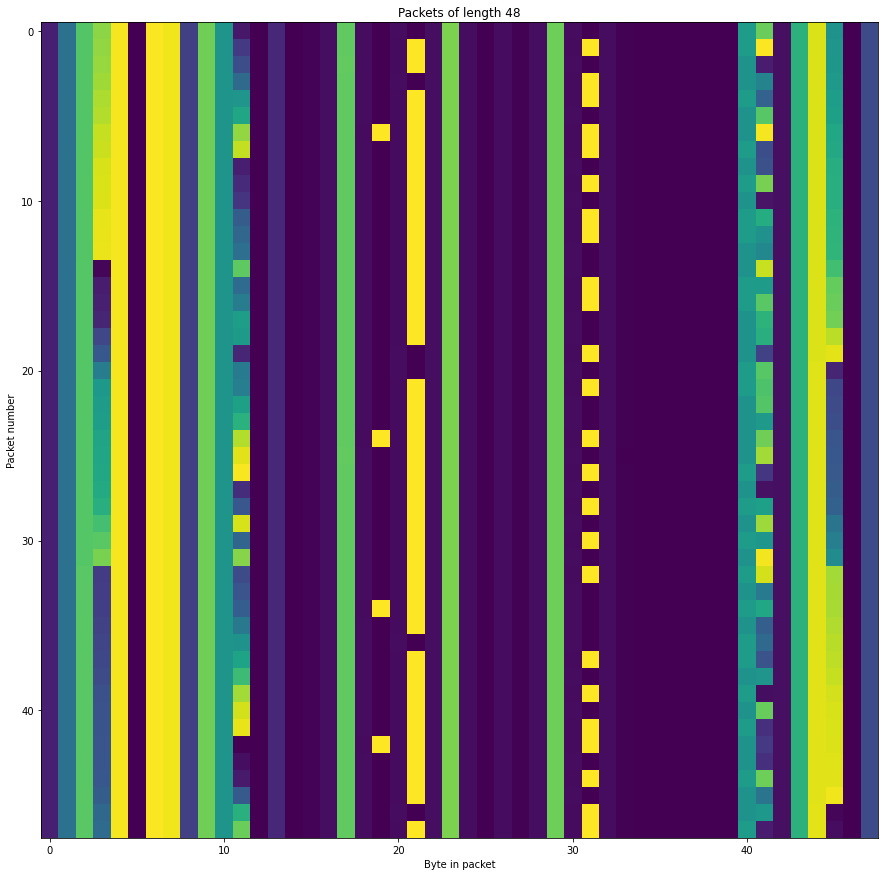

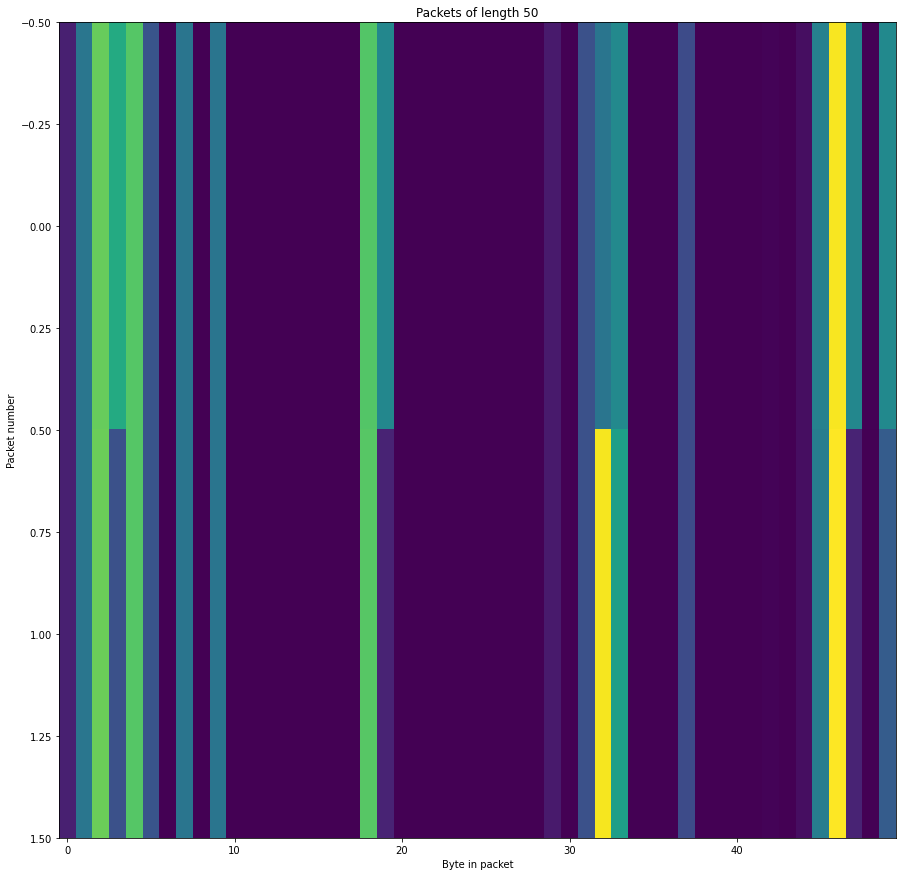

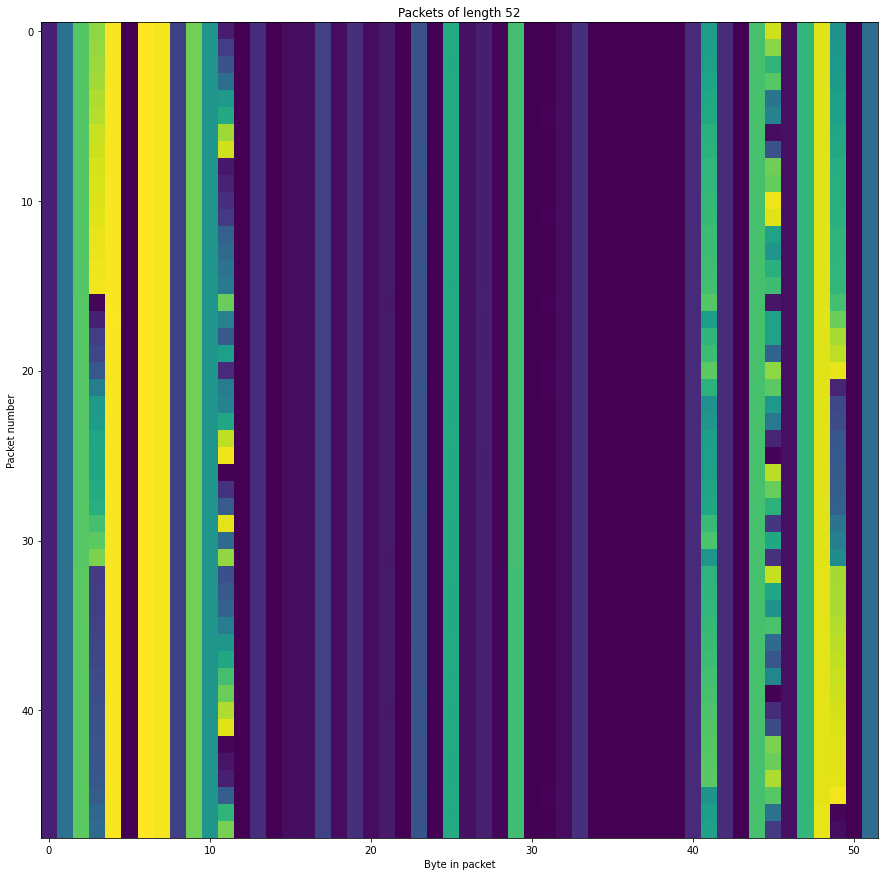

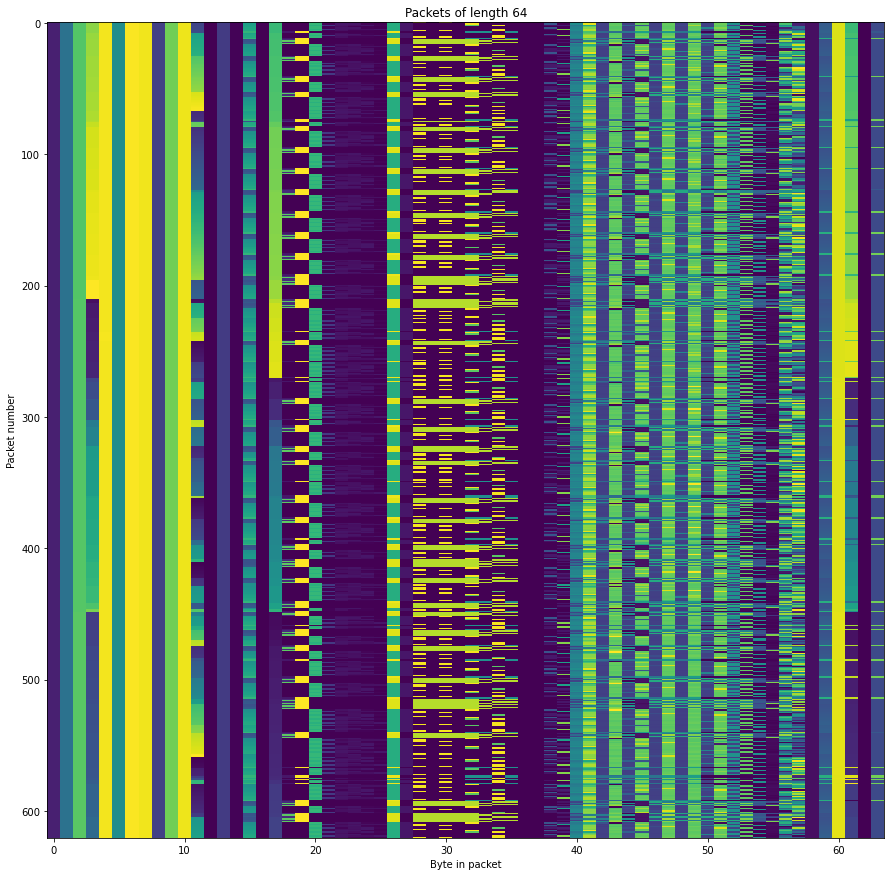

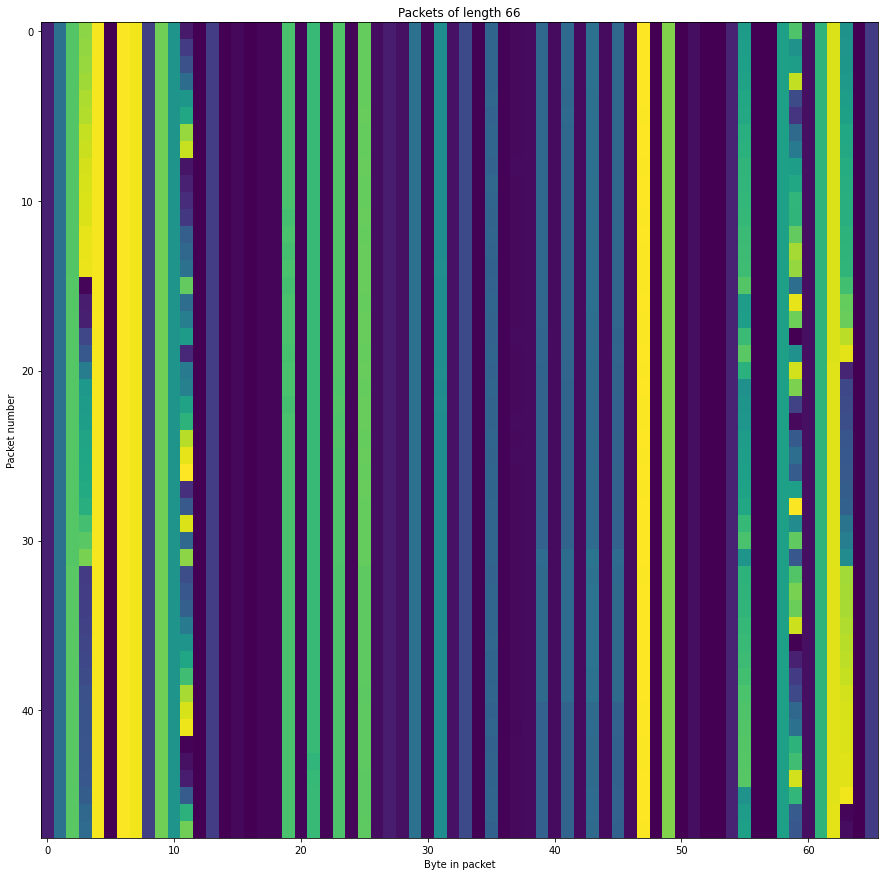

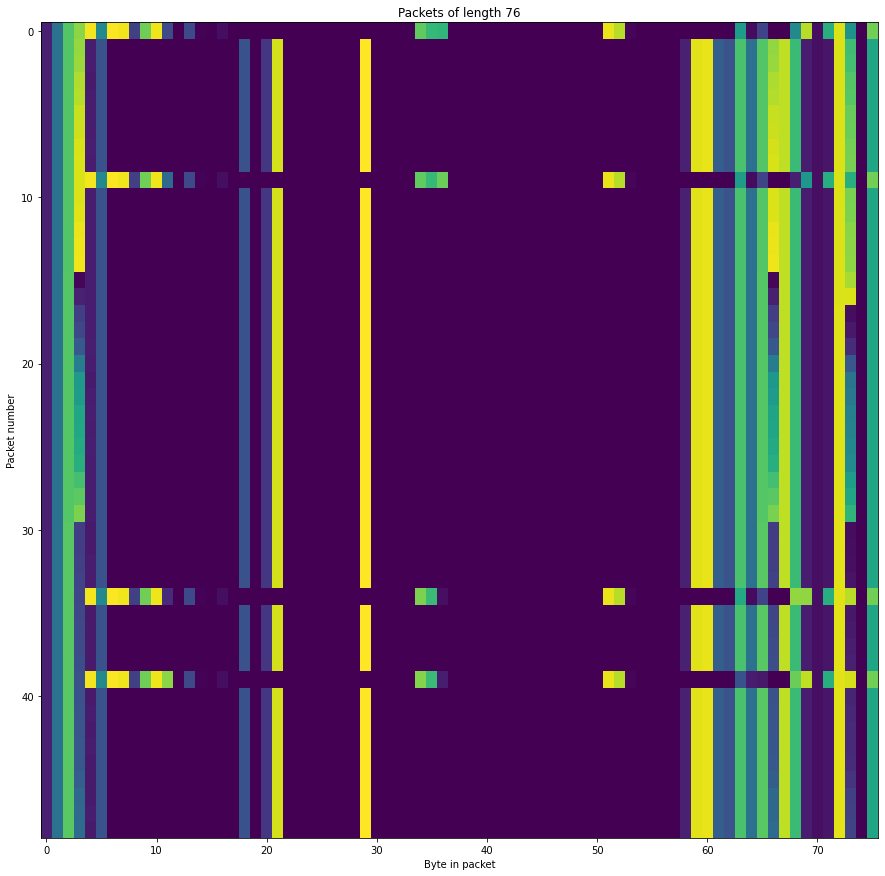

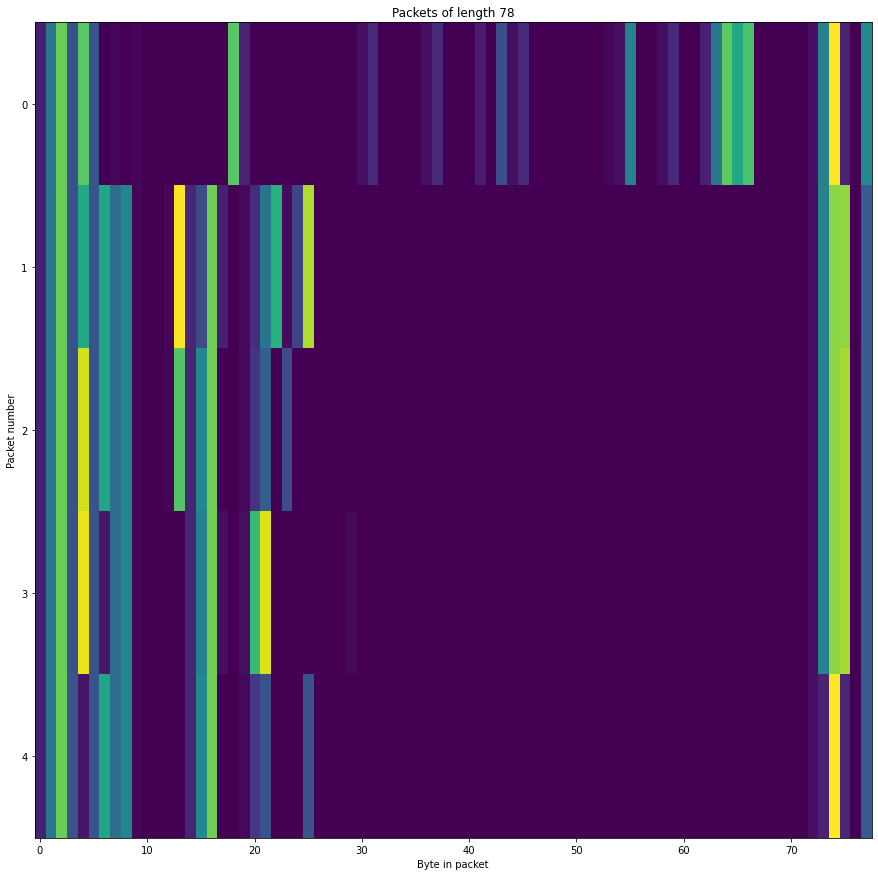

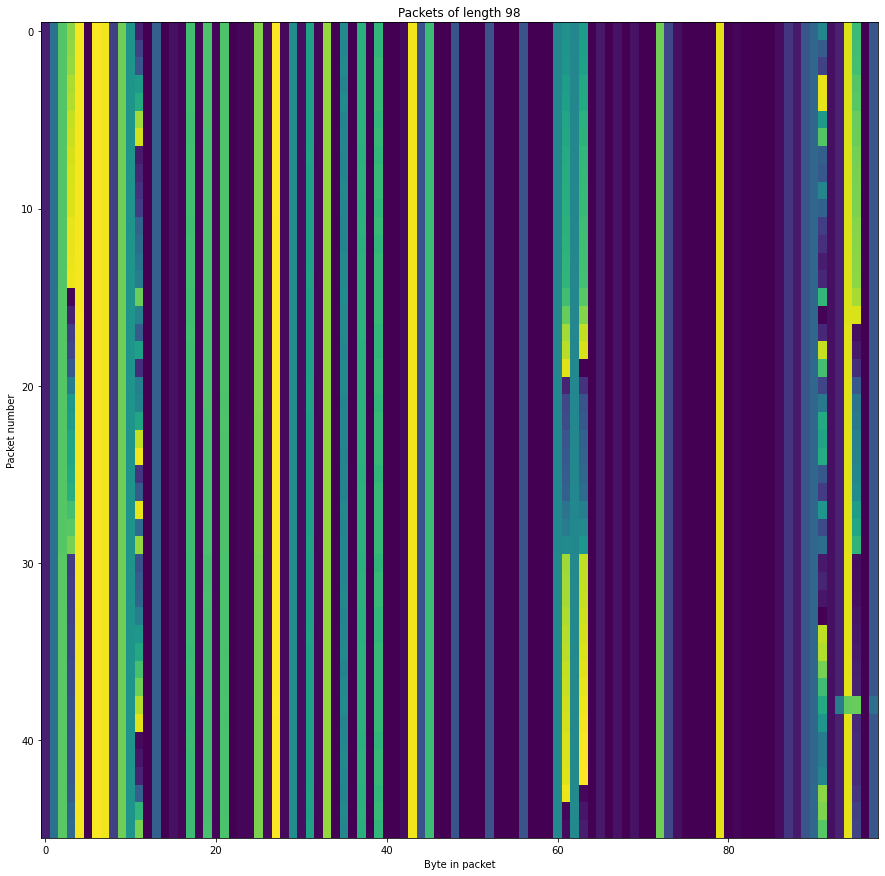

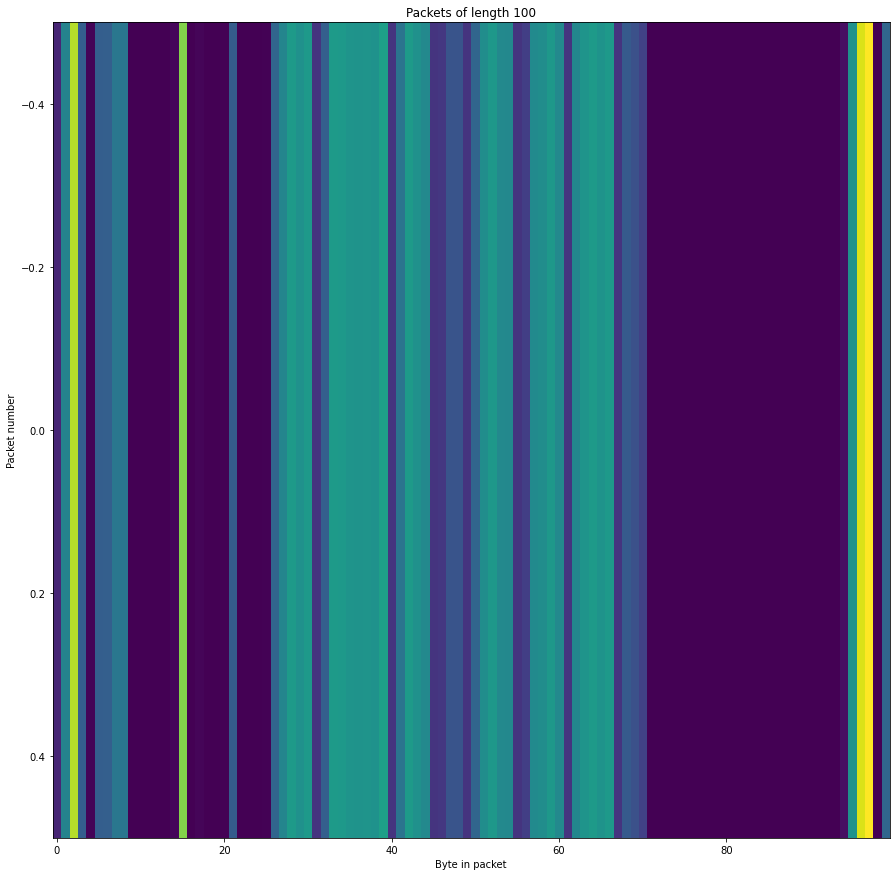

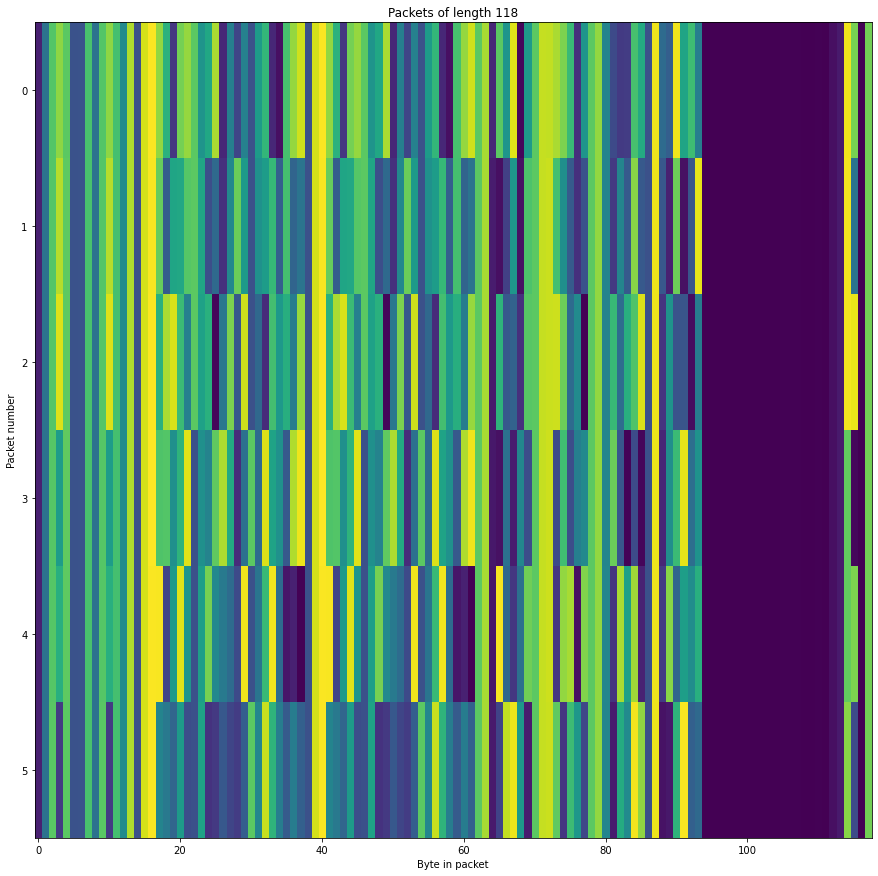

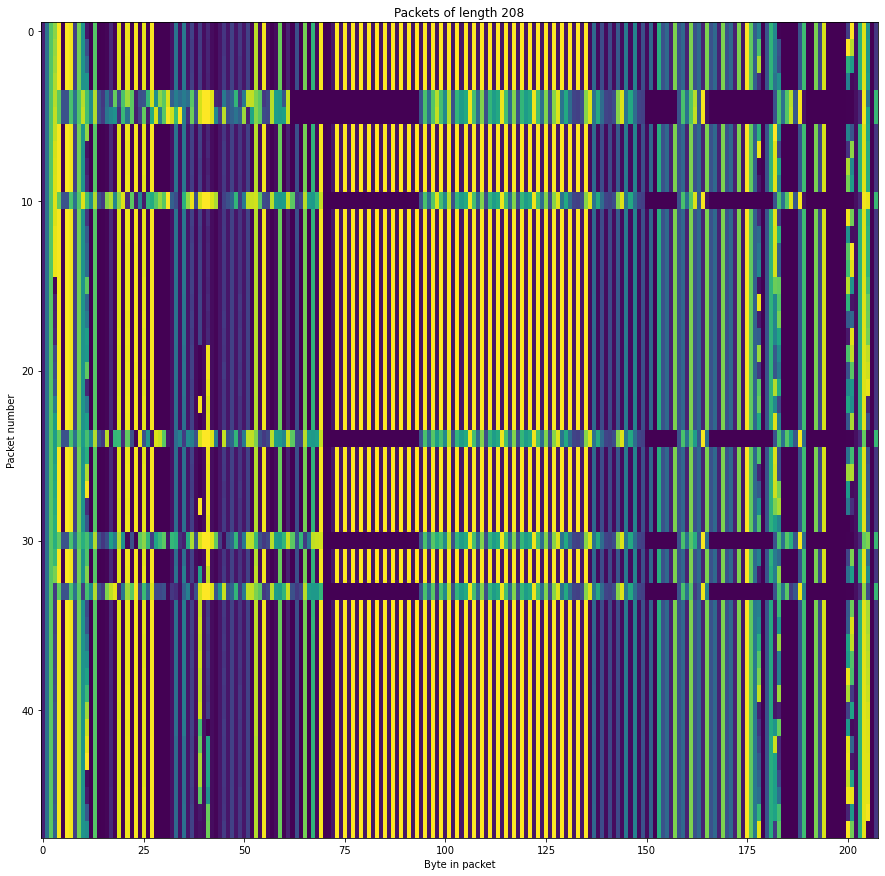

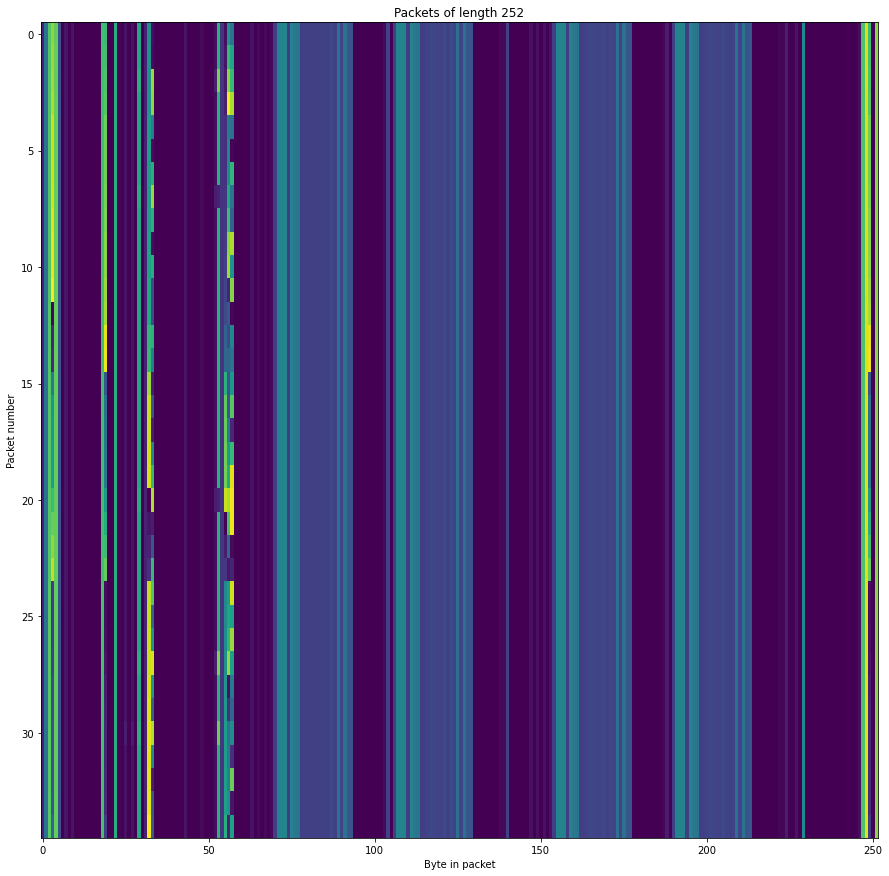

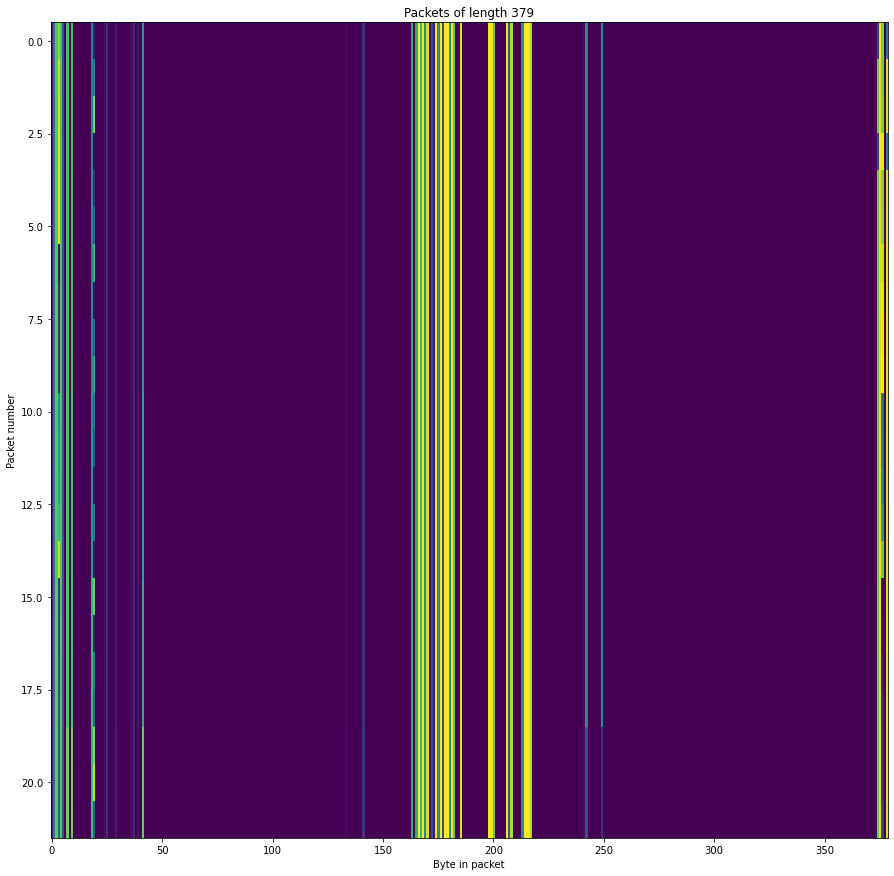

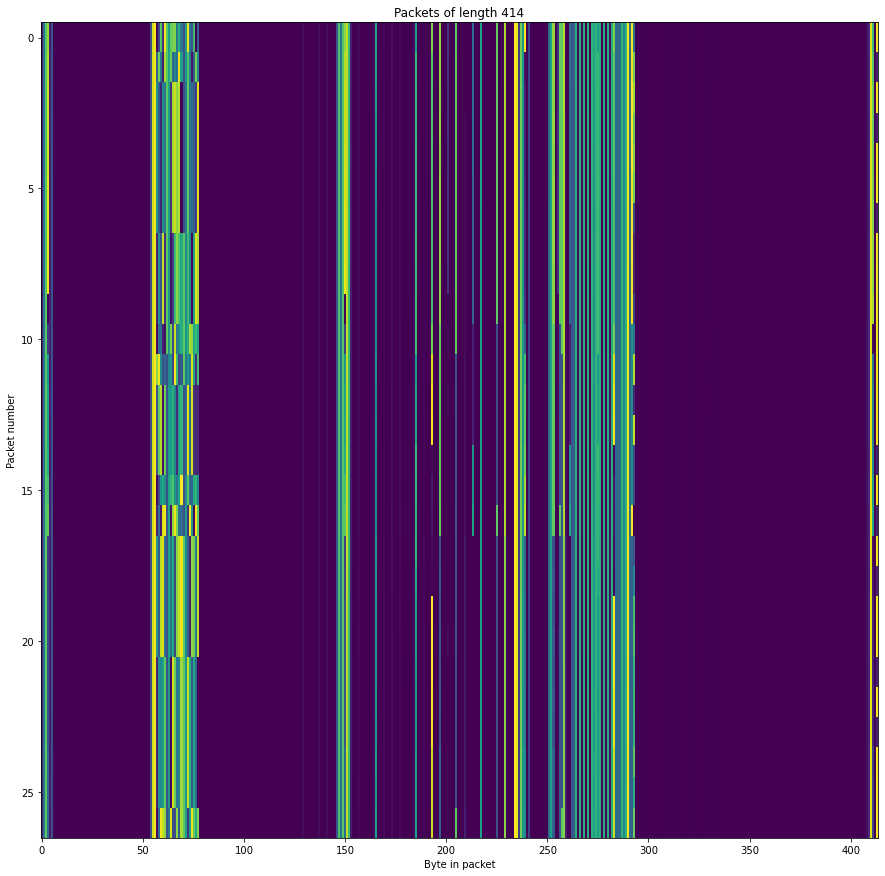

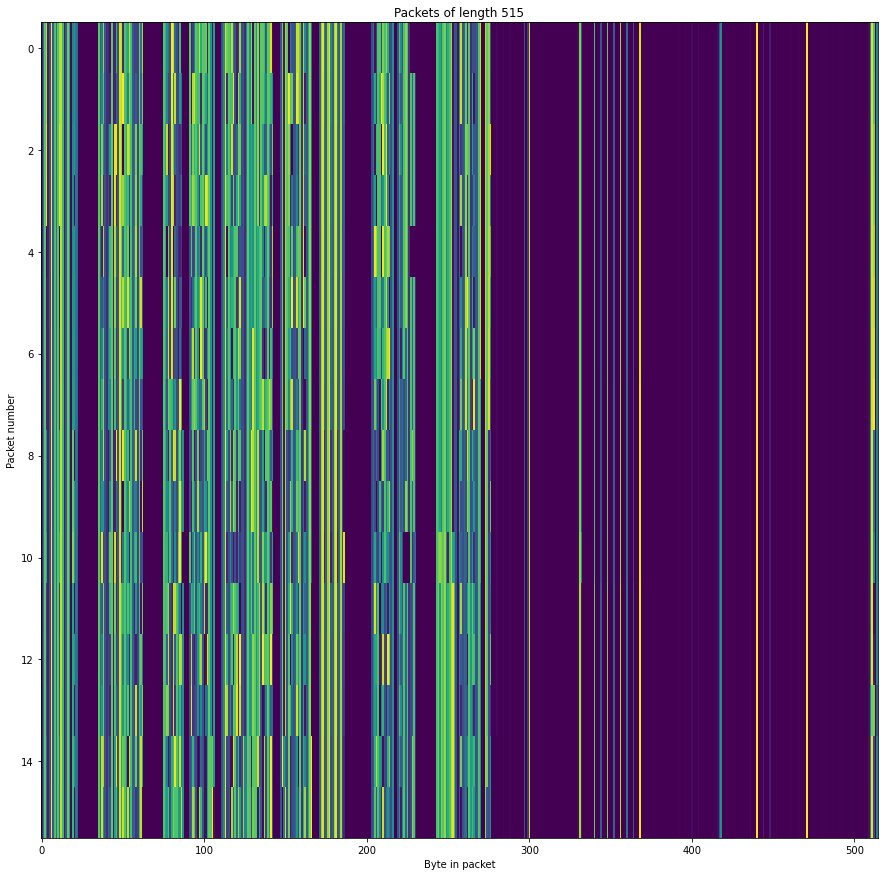

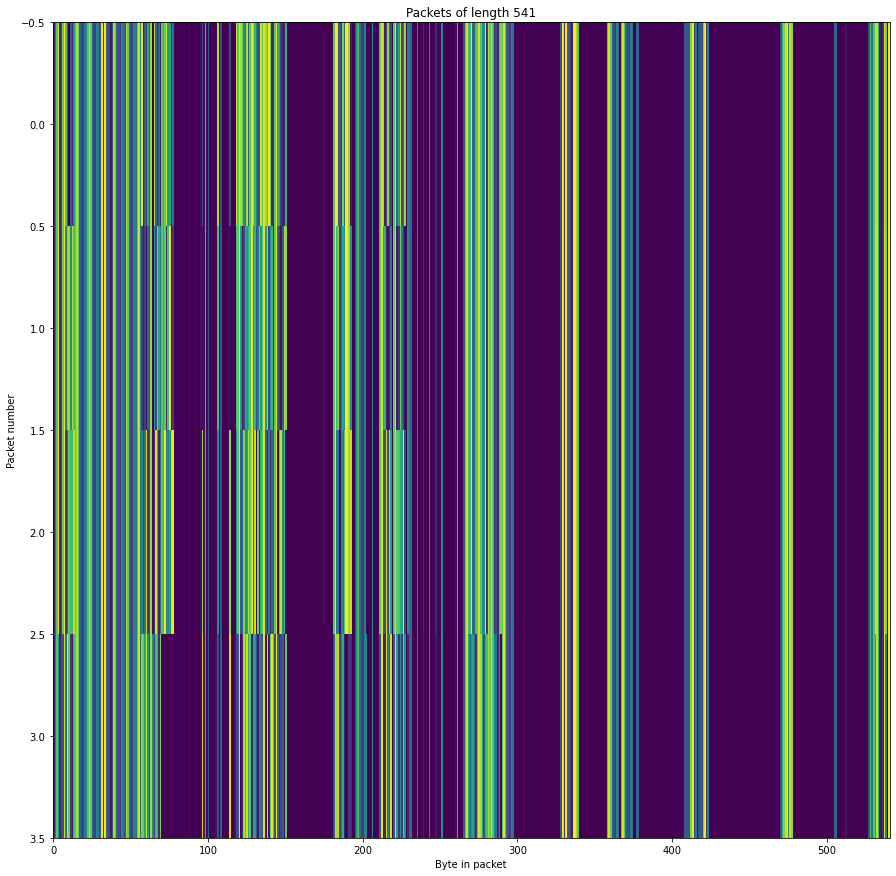

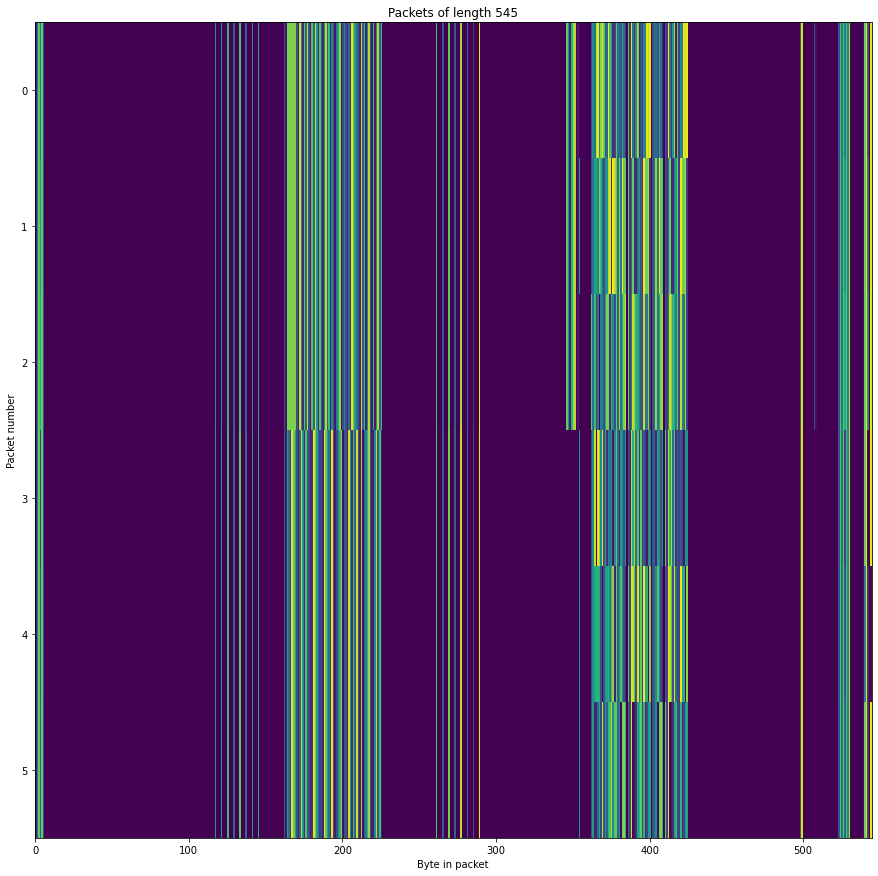

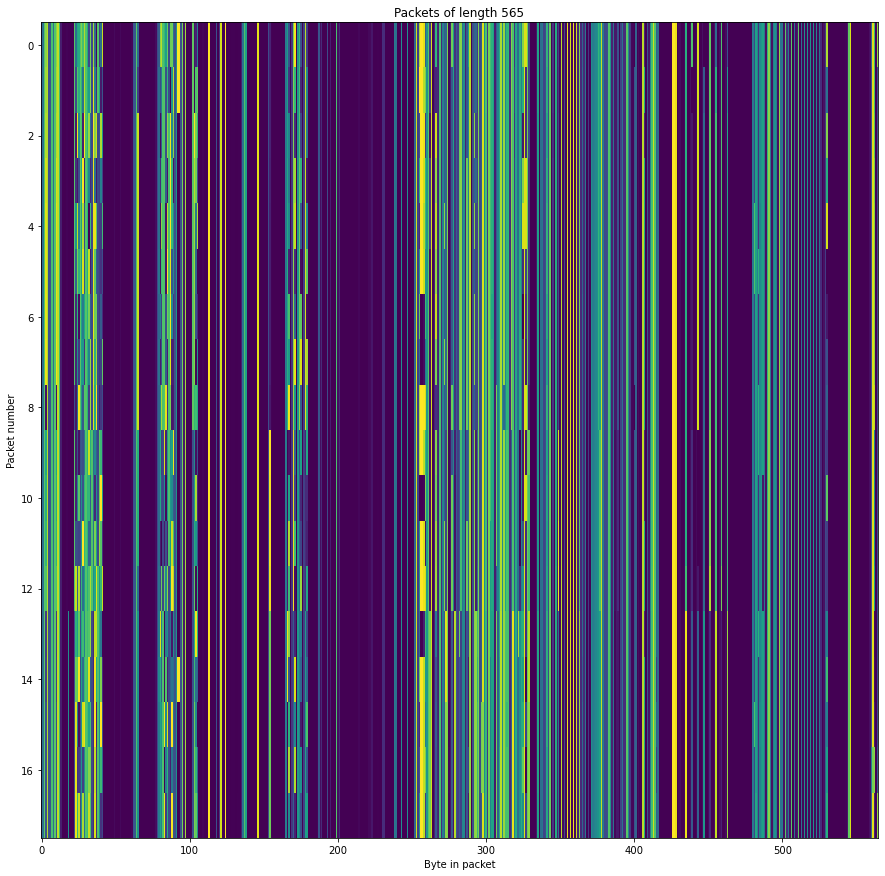

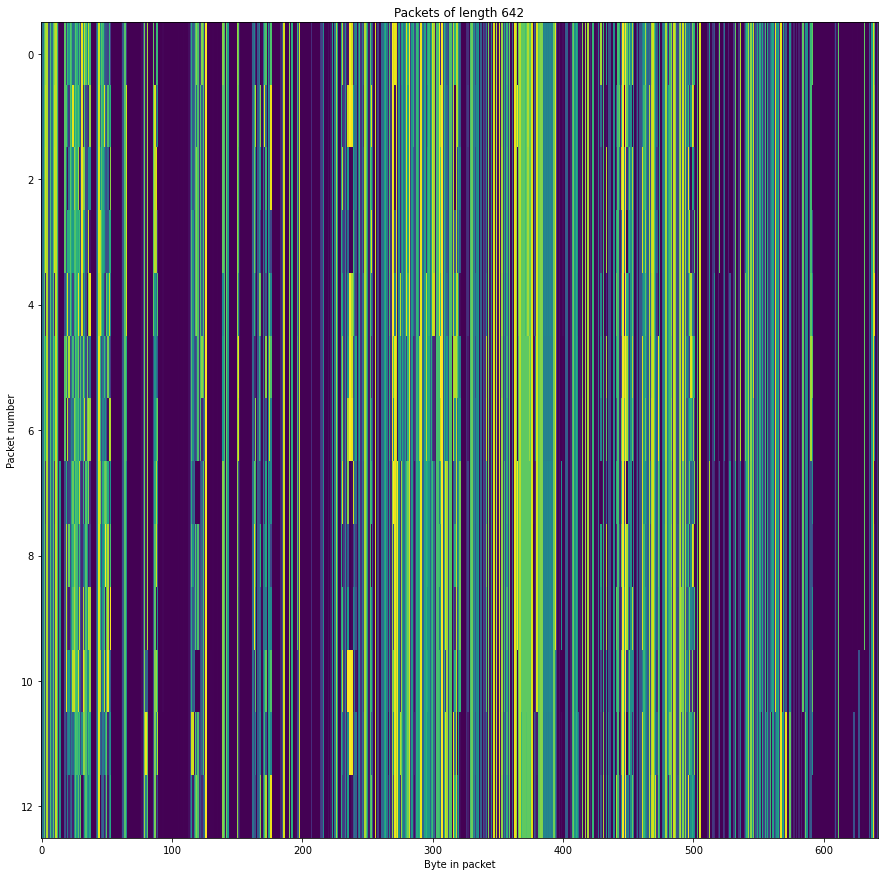

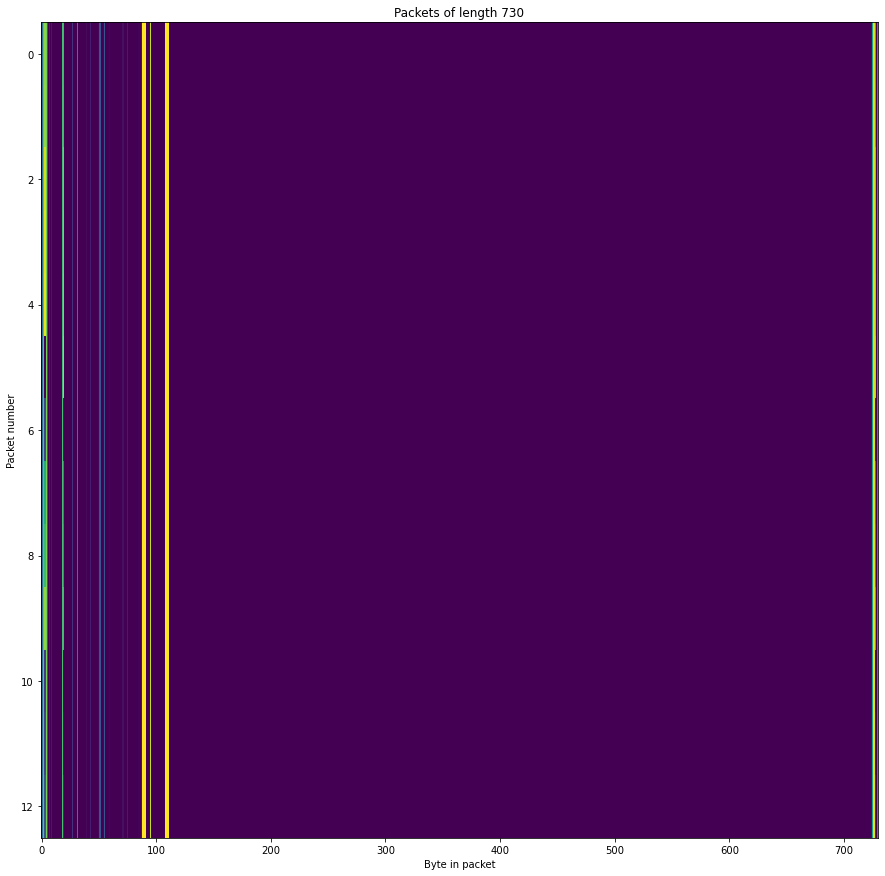

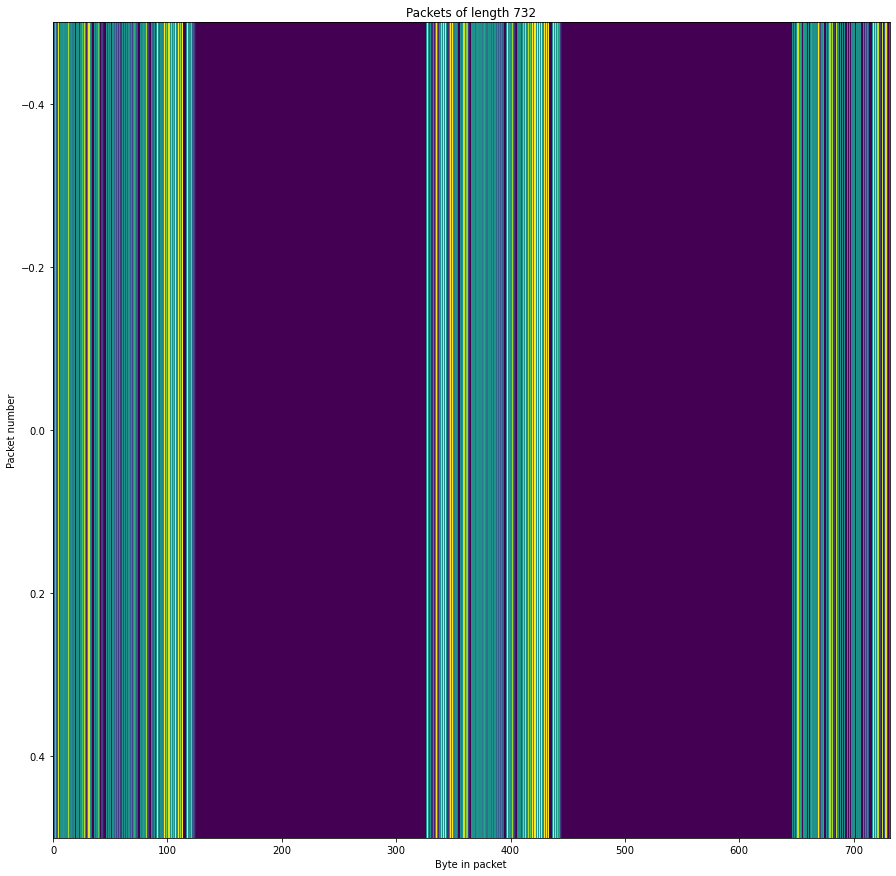

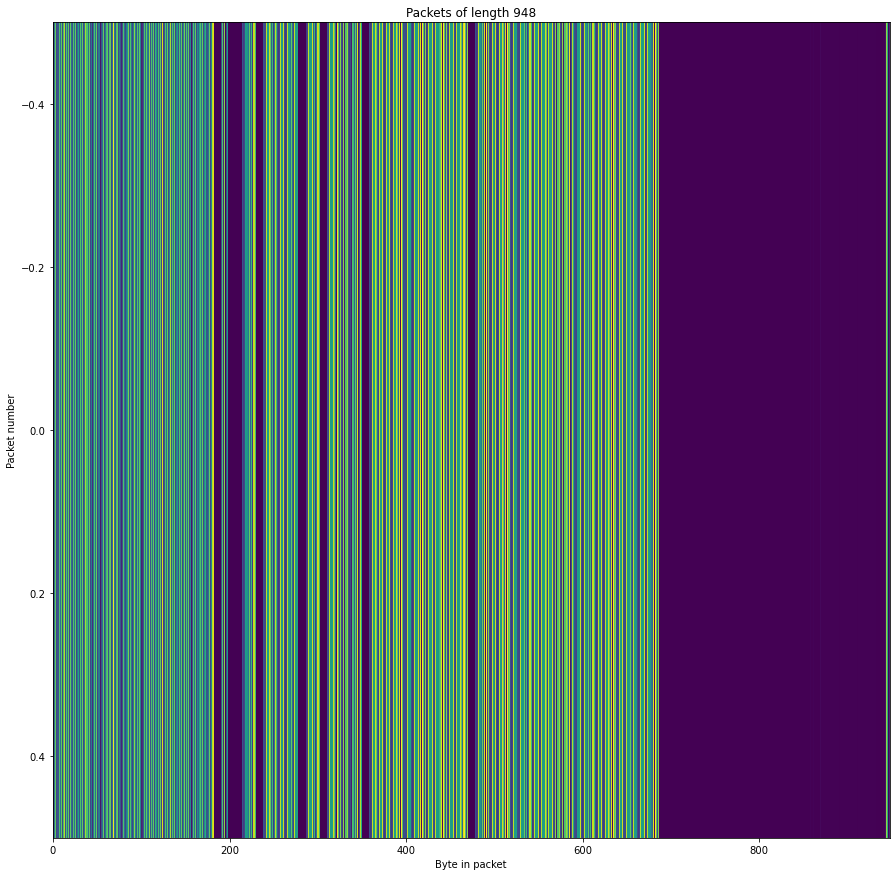

In [49]:
for length, packets in sorted(by_length.items()):
    plt.figure(figsize=(15, 15), facecolor='w')
    plt.imshow(packets, aspect='auto', interpolation='None')
    plt.title(f'Packets of length {length}')
    plt.ylabel('Packet number')
    plt.xlabel('Byte in packet');